<a href="https://colab.research.google.com/github/Freedisch/ml-protocol/blob/main/covidchat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Epoch 1/50
12/12 [==============================] - 2s 7ms/step - loss: 3.6421 - accuracy: 0.0486
Epoch 2/50
12/12 [==============================] - 0s 9ms/step - loss: 3.5317 - accuracy: 0.0764
Epoch 3/50
12/12 [==============================] - 0s 7ms/step - loss: 3.4875 - accuracy: 0.1181
Epoch 4/50
12/12 [==============================] - 0s 9ms/step - loss: 3.3901 - accuracy: 0.1667
Epoch 5/50
12/12 [==============================] - 0s 11ms/step - loss: 3.3335 - accuracy: 0.1389
Epoch 6/50
12/12 [==============================] - 0s 6ms/step - loss: 3.2403 - accuracy: 0.1944
Epoch 7/50
12/12 [==============================] - 0s 10ms/step - loss: 3.0881 - accuracy: 0.1944
Epoch 8/50
12/12 [==============================] - 0s 9ms/step - loss: 3.0368 - accuracy: 0.1944
Epoch 9/50
12/12 [==============================] - 0s 9ms/step - loss: 2.9703 - accuracy: 0.1944
Epoch 10/50
12/12 [==============================] - 0s 9ms/step - loss: 2.8477 - accuracy: 0.1875
Epoch 11/50
12/12

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


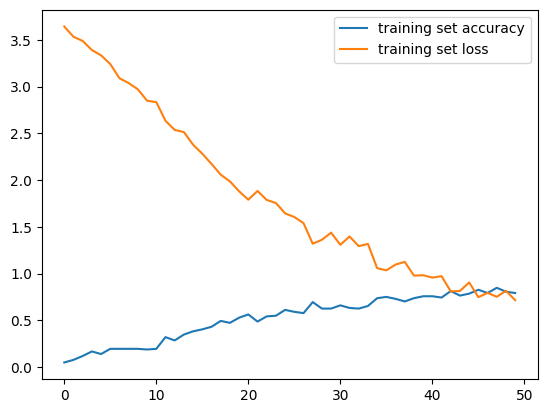

In [ ]:
import numpy as np
import pandas as pd
import re
import random
import transformers
import matplotlib.pyplot as plt
import json
import pickle
import torch

import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import metrics
from tensorflow.keras.models import load_model

from transformers import BertTokenizer, BertModel
from sklearn.preprocessing import LabelBinarizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

df = pd.read_csv("Covidbert.csv")
df.dropna(inplace=True)

dict_ = {"intents":[]}
for ind in df.index:
    ques = df['question'][ind].lower()
    ques = ques.replace('?', '.')
    ques += df['category'][ind].lower()
    ques = ques.split('.')
    for i, q in enumerate(ques):
        ques[i] = q.strip()
    ans = df['answer'][ind] + " check this link: " + df['link'][ind] +  "from the " + df['source'][ind]
    dict1 = {'tags': df['category'][ind]}
    dict1['patterns'] = ques[:-1]
    dict1['responses'] = ans
    dict_['intents'].append(dict1)

with open("covid.json", "w") as f:
    f.write(json.dumps(dict_))

with open('covid.json') as json_file:
    intents = json.load(json_file)

words = []
classes = []
documents = []
ignore_letters = ['?', '!', '.', ',']

for intent in intents['intents']:
    for pattern in intent['patterns']:
        if isinstance(pattern, str):
            pattern = pattern.strip()
            word_list = tokenizer.tokenize(pattern)
            words.extend(word_list)
            documents.append((pattern, intent['tags']))
            if intent['tags'] not in classes:
                classes.append(intent['tags'])

lemmatizer = WordNetLemmatizer()

words = [lemmatizer.lemmatize(w.lower()) for w in words if w not in ignore_letters]
words = sorted(set(words))
classes = sorted(set(classes))

pickle.dump(words, open('words.pkl', 'wb'))
pickle.dump(classes, open('classes.pkl', 'wb'))

train_x = []
train_y = []
output_empty = [0] * len(classes)

for doc in documents:
    bag = []
    pattern_words = doc[0].split()
    pattern_words = [lemmatizer.lemmatize(word.lower()) for word in pattern_words]
    for word in words:
        bag.append(1) if word in pattern_words else bag.append(0)
    train_x.append(bag)
    output_row = list(output_empty)
    output_row[classes.index(doc[1])] = 1
    train_y.append(output_row)

train_x = np.array(train_x)
train_y = np.array(train_y)

model = Sequential()
model.add(Dense(128, input_shape=(len(train_x[0]),), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(train_y[0]), activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
hist = model.fit(np.array(train_x), np.array(train_y), epochs=50, batch_size=12, verbose=1)
model.save('chatbotmodel.h5', hist)
print('Training Done')

plt.plot(hist.history['accuracy'], label='training set accuracy')
plt.plot(hist.history['loss'], label='training set loss')
plt.legend()
plt.show()



with open('covid.json') as json_file:
    intents = json.load(json_file)

words = pickle.load(open('words.pkl', 'rb'))
classes = pickle.load(open('classes.pkl', 'rb'))
model = load_model('chatbotmodel.h5')

embedding_adjuster = Sequential()
embedding_adjuster.add(Dense(len(train_x[0]), input_shape=(768,), activation='relu'))

def get_bert_embedding(sentence):
    inputs = tokenizer(sentence, return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
        outputs = bert_model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1).detach().numpy()
    return embeddings

def extract_class(sentence):
    embedding = get_bert_embedding(sentence)
    adjusted_embedding = embedding_adjuster.predict(embedding)
    res = model.predict(adjusted_embedding)[0]
    ERROR_THRESHOLD = 0.25
    results = [[i, r] for i, r in enumerate(res) if r > ERROR_THRESHOLD]
    results.sort(key=lambda x: x[1], reverse=True)
    return_list = []
    for r in results:
        return_list.append({'intent': classes[r[0]], 'probability': str(r[1])})
    return return_list

def get_response(intents_list, intents_json):
    tag = intents_list[0]['intent']
    list_of_intents = intents_json['intents']
    for i in list_of_intents:
        if tag in i['tags']:
            return i['responses']
    return None

while True:
    message = input("")
    if message.lower() in ['quit', 'exit']:
        print("Goodbye")
        break
    ints = extract_class(message)
    if len(ints) > 0:
        res = get_response(ints, intents)
        print(f"Bot: {res}")